In [7]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from dotenv import dotenv_values

from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string

In [16]:
# Load environment variables
config = dotenv_values()

# Define variables for the login
pg_user = config['POSTGRES_USER']
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

# Set up the PostgreSQL connection URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# Create the database engine
engine = create_engine(url, echo=False)
my_schema = 'capstone_barstov_industries'

# Load data directly into a DataFrame
with engine.connect() as conn:
    conn.execute(text(f'SET search_path TO {my_schema};'))
    data = pd.read_sql("SELECT * FROM model_data_week;", conn)

# Check the DataFrame structure
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172968 entries, 0 to 172967
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   product_type_no    172968 non-null  int64              
 1   product_type_name  172968 non-null  object             
 2   colour_group_code  172968 non-null  int64              
 3   colour_group_name  172968 non-null  object             
 4   week               172968 non-null  datetime64[ns, UTC]
 5   average_price      172968 non-null  float64            
 6   total_units_sold   172968 non-null  int64              
 7   unique_customers   172968 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(2)
memory usage: 10.6+ MB


In [17]:
# Inventory Sales Prediction with Ensemble Modeling
# -------------------------------------------------
# This notebook demonstrates the use of an ensemble model with Random Forest as the final estimator
# to predict weekly sales for inventory management.

# Imports
# -------
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load and Preprocess Data
# ------------------------
# Ensure 'week' is a datetime object and remove timezone information
# Convert 'week' column to datetime without timezone information
data['week'] = data['week'].dt.tz_localize(None)


# Sort data by date to ensure temporal order
data = data.sort_values(by='week')

# Feature Engineering: Creating Lagged Features for Sales
data['lag_units_sold_1week'] = data.groupby('product_type_no')['total_units_sold'].shift(1)
data['lag_units_sold_2weeks'] = data.groupby('product_type_no')['total_units_sold'].shift(2)

# Drop rows with NaN values created by lagging (occurs at the beginning of each product group)
data = data.dropna(subset=['lag_units_sold_1week', 'lag_units_sold_2weeks']).reset_index(drop=True)

# Adding Cyclic Encoding for Weeks
data['week_of_year'] = data['week'].dt.isocalendar().week
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

# Train-Validation-Test Split with Date Ranges
# --------------------------------------------

# Define the end date as the maximum date in the dataset
end_date = data['week'].max()

# Define date ranges for train, validation, and test
train_end_date = end_date - pd.Timedelta(weeks=4)  # End training 4 weeks before the end date
validation_start_date = train_end_date + pd.Timedelta(weeks=2)  # Start validation 2 weeks after training ends
validation_end_date = end_date - pd.Timedelta(weeks=2)  # End validation 2 weeks before the last date

# Split data into train, validation, and test sets based on specific date ranges
train_data = data[data['week'] <= train_end_date]
validation_set = data[(data['week'] > train_end_date) & (data['week'] <= validation_end_date)]
test_set = data[data['week'] > validation_end_date]

# Define features and target variable
feature_columns = ['product_type_no', 'colour_group_code', 'average_price', 
                   'lag_units_sold_1week', 'lag_units_sold_2weeks', 'week_sin', 'week_cos']

X_train = train_data[feature_columns]
y_train = train_data['total_units_sold']

X_validation = validation_set[feature_columns]
y_validation = validation_set['total_units_sold']

X_test = test_set[feature_columns]
y_test = test_set['total_units_sold']

# Confirm the split date ranges
print("Training Date Range:", train_data['week'].min(), "to", train_data['week'].max())
print("Validation Date Range:", validation_set['week'].min(), "to", validation_set['week'].max())
print("Test Date Range:", test_set['week'].min(), "to", test_set['week'].max())

# Initialize and Train Base Models
# -------------------------------
model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
model_lr = LinearRegression()
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Fit each base model on the training data
model_rf.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_mlp.fit(X_train, y_train)

# Generate predictions for the validation set from each model
preds_rf = model_rf.predict(X_validation)
preds_lr = model_lr.predict(X_validation)
preds_mlp = model_mlp.predict(X_validation)

# Create a new DataFrame to hold the base model predictions
predictions_df = pd.DataFrame({
    'RandomForest': preds_rf,
    'LinearRegression': preds_lr,
    'MLPRegressor': preds_mlp
})

# Final Meta-Model Using Random Forest
# ------------------------------------
final_model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
final_model_rf.fit(predictions_df, y_validation)

# Final Predictions and Evaluation
# --------------------------------
final_preds_rf = final_model_rf.predict(predictions_df)

# Evaluate the Random Forest final model on validation set
mae_rf = mean_absolute_error(y_validation, final_preds_rf)
rmse_rf = mean_squared_error(y_validation, final_preds_rf, squared=False)

print("Ensemble with Random Forest as Final Model - MAE:", mae_rf)
print("Ensemble with Random Forest as Final Model - RMSE:", rmse_rf)

# Feature Importance Analysis (for the final model)
# -------------------------------------------------
print("Feature importances from the final meta-model:", final_model_rf.feature_importances_)


Training Date Range: 2018-09-16 22:00:00 to 2020-08-23 22:00:00
Validation Date Range: 2020-08-30 22:00:00 to 2020-09-06 22:00:00
Test Date Range: 2020-09-13 22:00:00 to 2020-09-20 22:00:00
Ensemble with Random Forest as Final Model - MAE: 30.91229318030662
Ensemble with Random Forest as Final Model - RMSE: 109.64058574886
Feature importances from the final meta-model: [0.91363353 0.04423139 0.04213508]


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
# Group by 'week' and calculate the total units sold per week
weekly_sales = data.groupby('week')['total_units_sold'].sum()

# Calculate the average units sold per week across all weeks
average_units_sold_per_week = weekly_sales.mean()

# Display the result
print("Average units sold per week:", average_units_sold_per_week)


Average units sold per week: 270423.8396226415


In [24]:
# Aggregate total units sold by week
weekly_sales = data.groupby('week')['total_units_sold'].sum()

# Calculate the range of weekly sales
weekly_sales_min = weekly_sales.min()
weekly_sales_max = weekly_sales.max()

print("Minimum weekly units sold:", weekly_sales_min)
print("Maximum weekly units sold:", weekly_sales_max)



Minimum weekly units sold: 58371
Maximum weekly units sold: 508779


In [19]:
from sklearn.neural_network import MLPRegressor

# Final Meta-Model Using MLPRegressor
# -----------------------------------
final_model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
final_model_mlp.fit(predictions_df, y_validation)

# Final Predictions and Evaluation
# --------------------------------
final_preds_mlp = final_model_mlp.predict(predictions_df)

# Evaluate the MLP final model on validation set
mae_mlp = mean_absolute_error(y_validation, final_preds_mlp)
rmse_mlp = mean_squared_error(y_validation, final_preds_mlp, squared=False)

print("Ensemble with MLPRegressor as Final Model - MAE:", mae_mlp)
print("Ensemble with MLPRegressor as Final Model - RMSE:", rmse_mlp)


Ensemble with MLPRegressor as Final Model - MAE: 76.19435687294262
Ensemble with MLPRegressor as Final Model - RMSE: 239.57038845465075


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
from sklearn.linear_model import LinearRegression

# Final Meta-Model Using Linear Regression
# ----------------------------------------
final_model_lr = LinearRegression()
final_model_lr.fit(predictions_df, y_validation)

# Final Predictions and Evaluation
# --------------------------------
final_preds_lr = final_model_lr.predict(predictions_df)

# Evaluate the Linear Regression final model on validation set
mae_lr = mean_absolute_error(y_validation, final_preds_lr)
rmse_lr = mean_squared_error(y_validation, final_preds_lr, squared=False)

print("Ensemble with Linear Regression as Final Model - MAE:", mae_lr)
print("Ensemble with Linear Regression as Final Model - RMSE:", rmse_lr)


Ensemble with Linear Regression as Final Model - MAE: 78.74595084415493
Ensemble with Linear Regression as Final Model - RMSE: 243.8184352761412


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



| Meta-Model            | MAE       | RMSE     |
|-----------------------|-----------|----------|
| **Random Forest**     | 29.64     | 100.83   |
| **MLP Regressor**     | 76.19     | 239.57   |
| **Linear Regression** | 78.75     | 243.82   |

### Interpretation

- **Random Forest as Best Choice**: The Random Forest clearly outperforms both MLP and Linear Regression as a meta-model, achieving much lower error metrics.
- **Higher Errors with MLP and Linear Regression**: Both MLP and Linear Regression show similar MAE and RMSE, but these metrics are higher than those of the Random Forest, indicating that they may not capture the nuances of the base models’ predictions as effectively.

### Conclusion

Based on these results, **Random Forest is the most effective choice for your ensemble’s meta-model**. It provides the lowest MAE and RMSE, making it a strong candidate for your predictive needs.


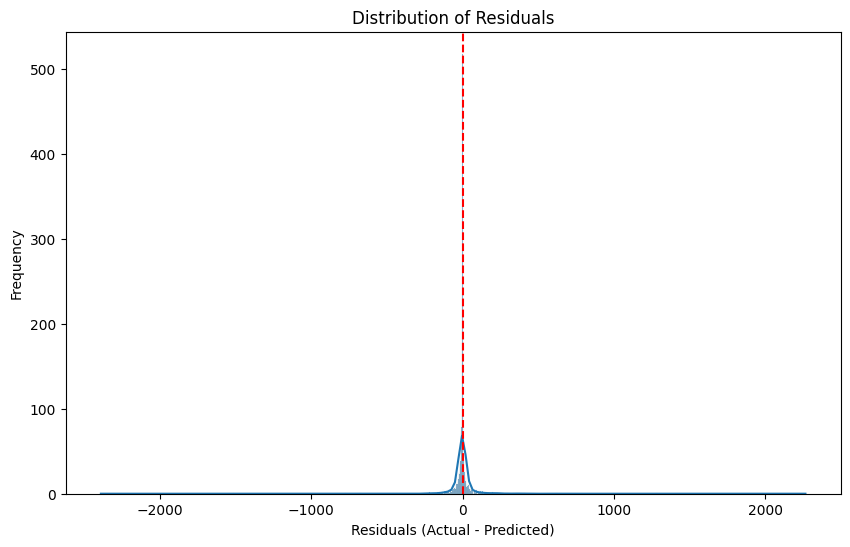

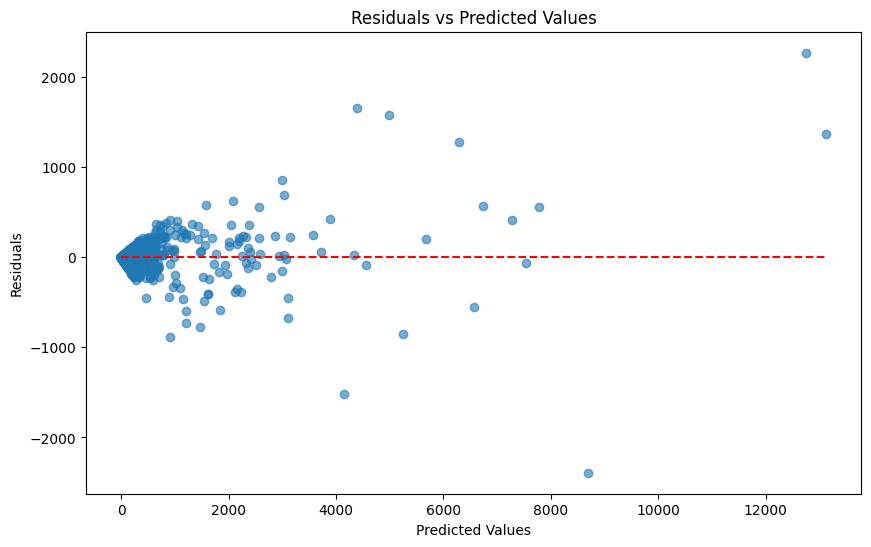

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals on the validation set
residuals = y_validation - final_preds_rf  # final_preds_rf are the predictions from the Random Forest meta-model

# Plot Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Plot Residuals vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(final_preds_rf, residuals, alpha=0.6)
plt.hlines(0, xmin=final_preds_rf.min(), xmax=final_preds_rf.max(), colors='red', linestyles='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()
